In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import *
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression as LR

from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1)  

In [3]:
df = pd.read_csv('Clean_data.csv', index_col=0)

df.drop(index = range(215, 274), inplace= True)
df.drop(columns=['Prop'], inplace= True)
df.head()

,Oil,Total,P1,P2,P3,P4,P5,P6
274,1.133333,1.700000,0.0,0.0,0.0,0.0,0.0,651.875000
275,1.000000,1.548387,0.0,0.0,0.0,0.0,0.0,653.333333
276,1.400000,2.000000,0.0,0.0,0.0,0.0,0.0,543.120000
277,1.250000,1.821429,0.0,0.0,0.0,0.0,0.0,556.666667
278,1.193548,1.741935,0.0,0.0,0.0,0.0,0.0,547.868852


In [4]:
# AR() Error 
def AR_Er(data_X, data_Y, p = 0):
    
    X = np.matrix(data_X)
    Y = np.array(data_Y)
    m = X.shape[1] # Amount of predictors
    n = X.shape[0] # Amount of observations

    LR_Init = LR().fit(X, Y) # Initial Linear model
    b_free = LR_Init.intercept_
    b_coef = LR_Init.coef_.copy()
    Predict = LR_Init.predict(X) 
    b_coef_new = np.zeros(m)+1e9
    b_free_new = 1e9
    
    Resid = Y - Predict
    if p==0:
        p = AR_Order(Resid)
    
    while((abs(b_free_new-b_free)>0.001)| np.all((abs(b_coef_new-b_coef)>0.001))):
        b_coef = b_coef_new.copy()
        b_free = b_free_new

        AR_Res = sm.tsa.ARIMA(Resid.transpose(), order=(p,0,0)).fit(full_output=False, disp=0)
        
        phi = AR_Res.params[1:].copy()
        beta = AR_Res.params[0]
        
        Y_Cohr = Y[p:].copy()
        for j in range(p):
            Y_Cohr = Y_Cohr - phi[j]*Y[p-(j+1):n-(j+1)] 
        
        X_Cohr = X[p:, :].copy()
        
        for i in range(m):
            for j in range(p):
                X_Cohr[0:, i] = X_Cohr[0:, i]-phi[j]*X[p-(j+1):n-(j+1),i]
            
        LR_Optim = LR().fit(X_Cohr, Y_Cohr)

        b_coef_new = LR_Optim.coef_.copy()
        b_free_new = LR_Optim.intercept_/(1-phi.sum())
        
        
        Predict = np.array(b_coef_new*X.transpose() + b_free_new)[0]
        Resid = Y - Predict
        
    New_Predict = np.zeros(n)
    
    for i in range(p):
        New_Predict[i] = Predict[i]
    for i in range(p,n):
        New_Predict[i] = Predict[i]
        for j in range(p):
            New_Predict[i] = New_Predict[i]+phi[j]*(Y[i-1-j]-Predict[i-1-j])
            
    return New_Predict, p, b_free_new, b_coef_new


In [5]:
# Check pacf and acf of residuals
def ARMA_Check(data_X, data_Y):
    X = np.matrix(data_X)
    Y = np.array(data_Y)
    LR_Regular = LR().fit(X, Y) # Initial Linear model
    
    Predict = LR_Regular.predict(X) 
    Resid = Y - Predict
    pl_acf = plot_acf(Resid)
    pl_pacf = plot_pacf(Resid)
    
    plt.rcParams["figure.figsize"] =(18,4)
    plt.show()

In [6]:
# Return AR order of error
def AR_Order(Resid):
    Order = 1
    while((pacf(Resid)>1/np.sqrt(len(Resid)))[Order]):
        Order+=1
    return Order-1

In [7]:
def OneCommonLag(l, use_df=df, show_ARMA = False, p=0):
    if l == 0:
        P_lag = np.array(use_df.iloc[:,2:])
    else:
        P_lag = np.array(use_df.iloc[:-l,2:])
    if show_ARMA:
        ARMA_Check(P_lag, use_df.Oil[l:])
    return AR_Er(P_lag, use_df.Oil[l:], p)

def TwoCommonLag(l, use_df=df, show_ARMA = False, p=0):
    max_l = max(l)
    size = len(use_df.iloc[:,2])
    P2_lag = np.array(pd.concat([use_df.iloc[max_l-l[0]:size-l[0],2:].reset_index(drop=True),
                                use_df.iloc[max_l-l[1]:size-l[1],2:].reset_index(drop=True)], axis=1))
    if show_ARMA:
        ARMA_Check(P2_lag, use_df.Oil[max_l:])
    return AR_Er(P2_lag, use_df.Oil[max_l:], p)

def GradientLag(l, use_df=df, show_ARMA = False, p=0):
    max_l = max(l)
    size = len(use_df.Oil)
    PG_lag = np.array(pd.concat([use_df.iloc[(max_l-l[0]):(size-l[0]),2].reset_index(drop=True),
                                 use_df.iloc[(max_l-l[1]):(size-l[1]),3].reset_index(drop=True),
                                 use_df.iloc[(max_l-l[2]):(size-l[2]),4].reset_index(drop=True),
                                 use_df.iloc[(max_l-l[3]):(size-l[3]),5].reset_index(drop=True),
                                 use_df.iloc[(max_l-l[4]):(size-l[4]),6].reset_index(drop=True),
                                 use_df.iloc[(max_l-l[5]):(size-l[5]),7].reset_index(drop=True)], axis=1))
    if show_ARMA:
        ARMA_Check(PG_lag, use_df.Oil[max_l:])
    return AR_Er(PG_lag, use_df.Oil[max_l:], p)

##### Let use common lag for every fragment of data

In [8]:
dfP6 = df.loc[274:370].copy()
dfP6= dfP6.drop(columns = ['P1', 'P2', 'P3', 'P4', 'P5'])
dfP3_6 = df.loc[371:521].copy()
dfP3_6  = dfP3_6.drop(columns = ['P1', 'P2'])
dfP_All = df.loc[522:].copy()

In [9]:
# %%time 
# df_res1 = pd.DataFrame()
# row  = 0

# for l in range(0, 18):
#     df_res1.loc[row, 0] = 'P6'
#     df_res1.loc[row, 1] = l
#     Predict, df_res1.loc[row, 2], b_free, b_coef = OneCommonLag(l, dfP6) 
#     df_res1.loc[row, 3] = mean_squared_error(dfP6.Oil[l:], Predict.transpose())
#     df_res1.loc[row, 4] = r2_score(dfP6.Oil[l:], Predict.transpose())
#     row += 1

# for l in range(0, 18):
#     df_res1.loc[row, 0] = 'P3_6'
#     df_res1.loc[row, 1] = l
#     Predict, df_res1.loc[row, 2], b_free, b_coef = OneCommonLag(l, dfP3_6) 
#     df_res1.loc[row, 3] = mean_squared_error(dfP3_6.Oil[l:], Predict.transpose())
#     df_res1.loc[row, 4] = r2_score(dfP3_6.Oil[l:], Predict.transpose())
#     row += 1

# for l in range(0, 18):
#     df_res1.loc[row, 0] = 'PAll'
#     df_res1.loc[row, 1] = l
#     Predict, df_res1.loc[row, 2], b_free, b_coef = OneCommonLag(l, dfP_All) 
#     df_res1.loc[row, 3] = mean_squared_error(dfP_All.Oil[l:], Predict.transpose())
#     df_res1.loc[row, 4] = r2_score(dfP_All.Oil[l:], Predict.transpose())
#     row += 1
    
# df_res1.rename(columns = {0: 'Mode', 1:'Lag',2:'AR order', 3: 'MSE', 4:'VS'}, inplace = True)
# df_res1.to_csv('3.1 Lag_1.csv')

In [10]:
df_res1 = pd.read_csv('3.1 Lag_1.csv', index_col=0)

df_res1.loc[df_res1.groupby('Mode')['VS'].idxmax()]

,Mode,Lag,AR order,MSE,VS
19,P3_6,1.0,3.0,4.817911,0.569771
14,P6,14.0,1.0,0.372653,0.859414
43,PAll,7.0,2.0,1.935127,0.791284


In [11]:
df_res1.sort_values(by = ['VS'],ascending=False)

,Mode,Lag,AR order,MSE,VS
14,P6,14.0,1.0,0.372653,0.859414
12,P6,12.0,1.0,0.369156,0.858850
17,P6,17.0,1.0,0.381272,0.856877
13,P6,13.0,1.0,0.385981,0.854099
15,P6,15.0,1.0,0.391023,0.853170
16,P6,16.0,1.0,0.403787,0.848392
0,P6,0.0,1.0,0.543904,0.844857
2,P6,2.0,1.0,0.533166,0.842378
1,P6,1.0,1.0,0.556118,0.838811
3,P6,3.0,1.0,0.543387,0.837153


In [12]:
# %%time 

# df_res2 = pd.DataFrame()
# row=0
# for l1 in range(1, 18):
#     for l2 in range(l1+1, 18):
#         df_res2.loc[row, 0] = 'P6'
#         lag = [l1,l2]
#         max_lag = max(lag)
#         Predict, df_res2.loc[row, 1], b_free, b_coef = TwoCommonLag(lag, dfP6)
#         df_res2.loc[row, 2] = l1
#         df_res2.loc[row, 3] = l2
#         df_res2.loc[row, 4] = mean_squared_error(dfP6.Oil[max_lag:], Predict.transpose())
#         df_res2.loc[row, 5] = r2_score(dfP6.Oil[max_lag:], Predict.transpose())
#         row+=1
        
# for l1 in range(1, 18):
#     for l2 in range(l1+1, 18):
#         df_res2.loc[row, 0] = 'P3_6'
#         lag = [l1,l2]
#         max_lag = max(lag)
#         Predict, df_res2.loc[row, 1], b_free, b_coef = TwoCommonLag(lag, dfP3_6)
#         df_res2.loc[row, 2] = l1
#         df_res2.loc[row, 3] = l2
#         df_res2.loc[row, 4] = mean_squared_error(dfP3_6.Oil[max_lag:], Predict.transpose())
#         df_res2.loc[row, 5] = r2_score(dfP3_6.Oil[max_lag:], Predict.transpose())
#         row+=1
        
# for l1 in range(1, 18):
#     for l2 in range(l1+1, 18):
#         df_res2.loc[row, 0] = 'PAll'
#         lag = [l1,l2]
#         max_lag = max(lag)
#         Predict, df_res2.loc[row, 1], b_free, b_coef = TwoCommonLag(lag, dfP_All)
#         df_res2.loc[row, 2] = l1
#         df_res2.loc[row, 3] = l2
#         df_res2.loc[row, 4] = mean_squared_error(dfP_All.Oil[max_lag:], Predict.transpose())
#         df_res2.loc[row, 5] = r2_score(dfP_All.Oil[max_lag:], Predict.transpose())
#         row+=1
            
# df_res2.rename(columns = {0:'Mode', 1:'AR', 2: 'L1', 3: 'L2', 4:'MSE', 5: 'VS'}, inplace = True)
# df_res2.to_csv('3.2 Lag_2.csv')

In [29]:
df_res2 = pd.read_csv('3.2 Lag_2.csv', index_col=0)
df_res2.loc[df_res2.groupby('Mode')['VS'].idxmax()]



,Mode,AR,L1,L2,MSE,VS
137,P3_6,3.0,1.0,3.0,4.821417,0.573317
122,P6,1.0,12.0,14.0,0.367539,0.861343
342,PAll,1.0,6.0,7.0,1.459128,0.842623


---- AR Error (3)
Mean squared error: 4.8389
Variance score: 0.5702
Coefficients:  [-0.00330193 -0.00454878 -0.00129964 -0.00571508]


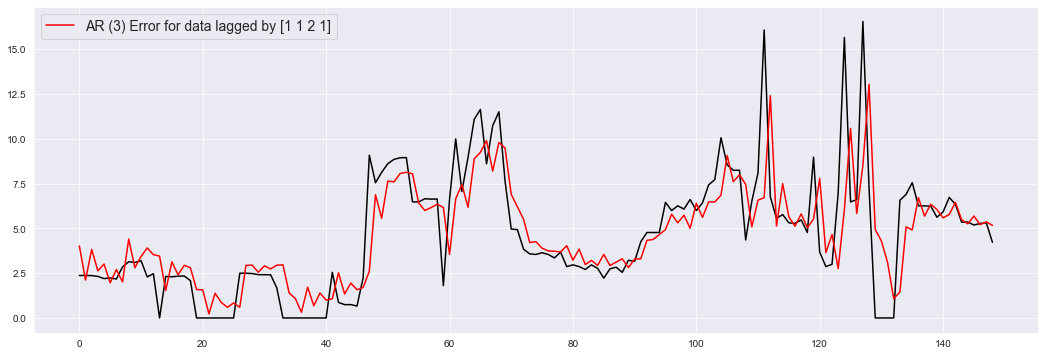

Influence of each pump with each lag
 [0.22212113 0.30599729 0.08742706 0.38445453]
Influence of each pump with each lag (absolute)
 [-0.22212113 -0.30599729 -0.08742706 -0.38445453]


In [45]:
# %%time

# def GradientLagP3_6(l, use_df=df, show_ARMA = False, p=0):
#     max_l = max(l)
#     size = len(use_df.Oil)
#     PG_lag = np.array(pd.concat([use_df.iloc[(max_l-l[0]):(size-l[0]),2].reset_index(drop=True),
#                                  use_df.iloc[(max_l-l[1]):(size-l[1]),3].reset_index(drop=True),
#                                  use_df.iloc[(max_l-l[2]):(size-l[2]),4].reset_index(drop=True),
#                                  use_df.iloc[(max_l-l[3]):(size-l[3]),5].reset_index(drop=True)], axis=1))
#     if show_ARMA:
#         ARMA_Check(PG_lag, use_df.Oil[max_l:])
#     return AR_Er(PG_lag, use_df.Oil[max_l:], p)

# df_res3_1 = pd.DataFrame()
# row = 0
# Lag_variants = [
#                 [1,1,1,1],
#                 [11,11,11,11],                
#                 [12,11,1,12],
#                ]
# for L in Lag_variants:
#     lag = L.copy()
#     max_lag = max(lag)
#     Predict, AR_used, b_free, b_coef = GradientLagP3_6(lag, dfP3_6)
#     M_base = mean_squared_error( dfP3_6.Oil[max_lag:], Predict.transpose())
#     M = M_base                  
#     for i in range( 4):
#         for j in range(i, i+4):
#             k = j%4
#             while(True):  
#                 lag[k] += 1
#                 max_lag = max(lag)
#                 df_res3_1.loc[row, 0] = lag[0]
#                 df_res3_1.loc[row, 1] = lag[1]
#                 df_res3_1.loc[row, 2] = lag[2]
#                 df_res3_1.loc[row, 3] = lag[3]
#                 Predict, df_res3_1.loc[row, 4], b_free, b_coef = GradientLagP3_6(lag, dfP3_6)
#                 MSE = mean_squared_error( dfP3_6.Oil[max_lag:], Predict.transpose())
#                 df_res3_1.loc[row, 5] = MSE
#                 df_res3_1.loc[row, 6] =  r2_score( dfP3_6.Oil[max_lag:], Predict.transpose())
#                 row +=1
#                 if (M<MSE):
#                     break
#                 M = MSE

#             lag[k] -= 1
#         lag = L.copy()
#         M = M_base

# df_res3_1.rename(columns = {0: 'P3 lag', 1:'P4 lag', 2: 'P5 lag', 
#                           3:'P6 lag',4:'AR order', 5: 'MSE', 6: 'VS'}, inplace = True)

# df_res3_1.sort_values(by = ['VS'],ascending=False).head()

lag = np.array(df_res3_1.loc[df_res3_1['MSE'].idxmin()].iloc[:4], int)

Predict_GL, AR_used, b_free, b_coef = GradientLagP3_6(lag, dfP3_6)
max_lag = max(lag)
plt.rcParams["figure.figsize"] =(18,6)
plt.plot(np.array(dfP3_6.Oil[max_lag:]), color = 'black')
print("---- AR Error (%.0f)" %(AR_used))
print("Mean squared error: %.4f" % mean_squared_error(dfP3_6.Oil[max_lag:], Predict_GL.transpose()))
print('Variance score: %.4f' % r2_score(dfP3_6.Oil[max_lag:], Predict_GL.transpose()))
print('Coefficients: ', b_coef)
plt.plot(Predict_GL.transpose(), label = 'AR (' + str(AR_used) + ') Error for data lagged by '+ str(lag), color = 'red')
plt.legend(fontsize = 14)
plt.show()

print('Influence of each pump with each lag\n', b_coef/b_coef.sum())
print('Influence of each pump with each lag (absolute)\n', b_coef/abs(b_coef).sum())

,P3 lag,P4 lag,P5 lag,P6 lag,AR order,MSE,VS
2,1.0,1.0,2.0,1.0,3.0,4.838850,0.570176
15,1.0,1.0,2.0,1.0,3.0,4.838850,0.570176
5,1.0,1.0,2.0,1.0,3.0,4.838850,0.570176
8,1.0,1.0,2.0,1.0,3.0,4.838850,0.570176
0,2.0,1.0,1.0,1.0,3.0,4.919339,0.563027


In [22]:
%%time



df_res3 = pd.DataFrame()
row = 0
Lag_variants = [
                [1,1,1,1,1,1],
                [11,11,11,11,11,11],                
                [3,2,12,11,1,12],
               ]
for L in Lag_variants:
    lag = L.copy()
    max_lag = max(lag)
    Predict, AR_used, b_free, b_coef = GradientLag(lag, dfP_All)
    M_base = mean_squared_error(dfP_All.Oil[max_lag:], Predict.transpose())
    M = M_base                  
    for i in range( 6):
        for j in range(i, i+6):
            k = j%6
            while(True):  
                lag[k] += 1

                max_lag = max(lag)
                df_res3.loc[row, 0] = lag[0]
                df_res3.loc[row, 1] = lag[1]
                df_res3.loc[row, 2] = lag[2]
                df_res3.loc[row, 3] = lag[3]
                df_res3.loc[row, 4] = lag[4]
                df_res3.loc[row, 5] = lag[5]
                Predict, df_res3.loc[row, 6], b_free, b_coef = GradientLag(lag, dfP_All)
                MSE = mean_squared_error(dfP_All.Oil[max_lag:], Predict.transpose())
                df_res3.loc[row, 7] = MSE
                df_res3.loc[row, 8] =  r2_score(dfP_All.Oil[max_lag:], Predict.transpose())
                row +=1
                if (M<MSE):
                    break
                M = MSE

            lag[k] -= 1
        lag = L.copy()
        M = M_base

df_res3.rename(columns = {0:'P1 lag',1:'P2 lag', 2: 'P3 lag', 3:'P4 lag', 4: 'P5 lag', 
                          5:'P6 lag',6:'AR order', 7: 'MSE', 8: 'VS'}, inplace = True)
df_res3

Wall time: 1min 35s


,P1 lag,P2 lag,P3 lag,P4 lag,P5 lag,P6 lag,AR order,MSE,VS
0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,12.776525,-0.026717
1,1.0,2.0,1.0,1.0,1.0,1.0,4.0,11.815014,0.050549
2,1.0,1.0,2.0,1.0,1.0,1.0,2.0,4.232232,0.659899
3,1.0,1.0,3.0,1.0,1.0,1.0,2.0,2.465994,0.779961
4,1.0,1.0,4.0,1.0,1.0,1.0,2.0,2.624167,0.761888
5,1.0,1.0,3.0,2.0,1.0,1.0,2.0,2.464087,0.780131
6,1.0,1.0,3.0,3.0,1.0,1.0,2.0,2.457603,0.780710
7,1.0,1.0,3.0,4.0,1.0,1.0,2.0,2.498264,0.773312
8,1.0,1.0,3.0,3.0,2.0,1.0,2.0,2.499885,0.776937
9,1.0,1.0,3.0,3.0,1.0,2.0,2.0,2.476865,0.778991


In [23]:
df_res3.sort_values(by = ['VS'],ascending=False).head()

,P1 lag,P2 lag,P3 lag,P4 lag,P5 lag,P6 lag,AR order,MSE,VS
65,11.0,13.0,12.0,13.0,11.0,11.0,1.0,1.597832,0.796588
75,11.0,13.0,12.0,13.0,11.0,11.0,1.0,1.597832,0.796588
64,11.0,13.0,12.0,12.0,11.0,11.0,1.0,1.621450,0.793581
74,11.0,13.0,12.0,12.0,11.0,11.0,1.0,1.621450,0.793581
24,1.0,1.0,3.0,3.0,1.0,1.0,2.0,2.457603,0.780710


In [15]:
df_res3 = pd.read_csv('3.3 Gradient Lag.csv', index_col=0)
df_res3.sort_values(by = ['MSE'],ascending=True).head()

,P1 lag,P2 lag,P3 lag,P4 lag,P5 lag,P6 lag,AR order,MSE
111,11.0,13.0,12.0,13.0,11.0,11.0,1.0,1.597832
101,11.0,13.0,12.0,13.0,11.0,11.0,1.0,1.597832
110,11.0,13.0,12.0,12.0,11.0,11.0,1.0,1.621450
100,11.0,13.0,12.0,12.0,11.0,11.0,1.0,1.621450
256,13.0,14.0,14.0,13.0,13.0,14.0,1.0,1.702932


---- AR Error (1)
Mean squared error: 1.5978
Variance score: 0.7966
Coefficients:  [ 0.00250751 -0.00021295  0.00122288  0.00518626 -0.00210444  0.00303966]


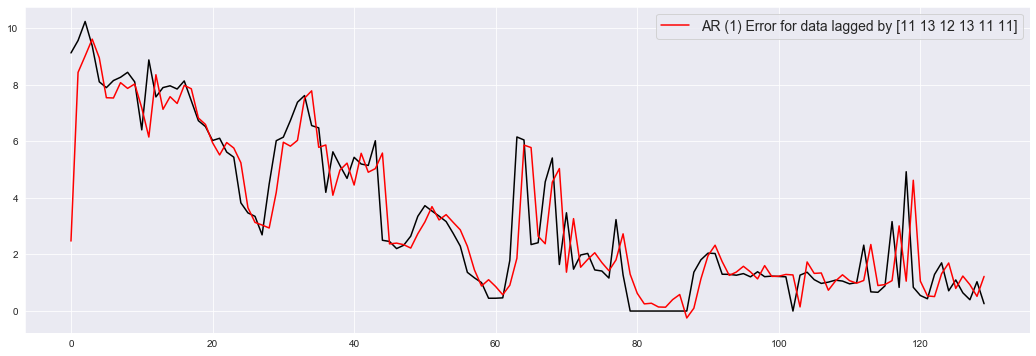

Influence of each pump with each lag
 [ 0.26014476 -0.02209241  0.12686851  0.53805408 -0.21832768  0.31535275]
Influence of each pump with each lag (absolute)
 [ 0.17567376 -0.01491883  0.08567333  0.36334379 -0.14743501  0.21295529]


In [16]:
lag = np.array(df_res3.loc[df_res3['MSE'].idxmin()].iloc[:6], int)

Predict_GL, AR_used, b_free, b_coef = GradientLag(lag, dfP_All)
max_lag = max(lag)
GL_index = np.array(dfP_All.index[max_lag:])
plt.rcParams["figure.figsize"] =(18,6)
plt.plot(np.array(dfP_All.Oil[max_lag:]), color = 'black')
print("---- AR Error (%.0f)" %(AR_used))
print("Mean squared error: %.4f" % mean_squared_error(dfP_All.Oil[max_lag:], Predict_GL.transpose()))
print('Variance score: %.4f' % r2_score(dfP_All.Oil[max_lag:], Predict_GL.transpose()))
print('Coefficients: ', b_coef)
plt.plot(Predict_GL.transpose(), label = 'AR (' + str(AR_used) + ') Error for data lagged by '+ str(lag), color = 'red')
plt.legend(fontsize = 14)
plt.show()

print('Influence of each pump with each lag\n', b_coef/b_coef.sum())
print('Influence of each pump with each lag (absolute)\n', b_coef/abs(b_coef).sum())